In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import random

SEED = 31415926
random.seed(SEED)
np.random.seed(SEED)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Table also can be found here: https://docs.google.com/spreadsheets/d/1VOAnyBxzia71Gcv_MgTcDT4W06Wl2_4N/edit#gid=996240860
DATA_PATH = "data/2023_02_21_Copy of Single cell studies database_final.csv"
# DATA_PATH = "http://www.nxn.se/single-cell-studies/data.tsv"

In [3]:
df = pd.read_csv(DATA_PATH, index_col=0)
df

,Shorthand,DOI,Number individuals,N_individulas sentence,chatgpt_sentence,Organism,Reported cells total,Tissue,Tissue_type,tissue_accessibility,...,PCA,tSNE,H5AD location,Isolation,BC --> Cell ID _OR_ BC --> Cluster ID,DOI_oroginal,do_DOI_match,Shorthand_origina,do_shorthands_match,Number individuals original
0.0,Cauli et al PNAS,10.1073/pnas.97.11.6144,NaN,NaN,NaN,Rat,85,Brain,NaN,NaN,...,Yes,No,NaN,Patch-clamp,NaN,10.1073/pnas.97.11.6144,1.0,Cauli et al PNAS,1.0,NaN
1.0,Malnic et al Cell,10.1016/S0092-8674(00)80581-4,NaN,NaN,NaN,Mouse,18,Brain,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.1016/S0092-8674(00)80581-4,1.0,Malnic et al Cell,1.0,NaN
2.0,Tietjen et al Neuron,10.1016/S0896-6273(03)00229-0,2.0,This prompted us to harvest OSNs and OPCs from...,There is no specific information given in the ...,"Human, Mouse",37,Brain,Brain,3.0,...,NaN,NaN,NaN,"Manual, LCM",NaN,10.1016/S0896-6273(03)00229-0,1.0,Tietjen et al Neuron,1.0,NaN
3.0,Gallopin et al CCortex,10.1093/cercor/bhj081,NaN,NaN,NaN,Rat,157,Brain,NaN,NaN,...,Yes,No,NaN,Patch-clamp,NaN,10.1093/cercor/bhj081,1.0,Gallopin et al CCortex,1.0,NaN
4.0,Kurimoto et al NAR,10.1093/nar/gkl050,NaN,NaN,NaN,Mouse,20,ICM,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.1093/nar/gkl050,1.0,Kurimoto et al NAR,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.1101/2023.03.01.530693,NaN,Shi et al bioRxiv,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.1101/2023.03.06.531348,NaN,Zhang et al bioRxiv,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.1101/2023.03.06.531307,NaN,Langlieb et al bioRxiv,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.1101/2023.03.10.531983,NaN,McFaline-Figueroa et al bioRxiv,NaN,NaN


In [4]:
is_included = (df["Tissue"] != "Culture") & \
              (df["Tissue"] != "Cullture") & \
              (df["Tissue"] != "Organoid") & \
              (df["Tissue"] != "Xenodraft") & \
              (df["Organism"].str.contains("Human")) & \
              (df["excluded"].isna())

print("Before exclusion:", df.shape)
df = df.loc[is_included, :]
print("After exclusion:", df.shape)

Before exclusion: (1858, 38)
After exclusion: (632, 38)


In [5]:
df["Number individuals"].notna().sum()

632

In [6]:
df["Organism"].value_counts()

Organism
Human                                                                        547
Human, Mouse                                                                  67
Mouse, Human                                                                   6
Human, Macaque                                                                 2
Human, Rhesus, Rat, Mouse, Rabbit, Pig                                         1
Human, Mouse, Pig                                                              1
Human, Frog                                                                    1
Human, Zebrafish, Chicken, Marmoset, Sheep, Hamster, Mouse, Rat, Mole rat      1
Crab-eating macaque, Human                                                     1
Mouse, Human, Dog                                                              1
Cynomolgus macaque, Human, Mouse, Pig, Rhesus macaque                          1
Bonobo, Chimpanzee, Human, Macaque                                             1
Human, Macaque, Mou

In [7]:
df["Tissue_type"].value_counts()

Tissue_type
Blood                     127
Brain                      98
Several                    66
Digestive system           52
Tumor                      45
Respiratory system         37
Reproductive system        33
Bone marrow                26
Pancreas                   24
Cardiovascular system      19
Urinary system             19
Musculoskeletal system     17
Visual system              16
Skin                       15
Lymphoid system            12
Breast                      9
Embryo                      8
Xenograft                   3
Adipose                     3
Cerebrospinal fluid         2
Endocrine system            1
Name: count, dtype: int64

In [8]:
df["tissue_accessibility"].value_counts()

tissue_accessibility
3.0    460
1.0    129
2.0     43
Name: count, dtype: int64

In [9]:
def get_date(number):
    """Extract year, month and day from the date in form of integer number
    
    Examples
    --------
    >>> get_date(20020726)
    (2020, 26, 07)
    """

    if "/" in number:
        day, month, year = number.split("/")

    else:
        if len(str(number)) != 8:
            raise ValueError(f"{number} has incorrect format")

        number = str(number)
        year = number[:4]
        month = number[4:6]
        day = number[6:]

    return year, month, day


def remove_comma_from_number(s):
    if isinstance(s, str):
        return s.replace(",", "")
    
    return s

In [10]:
accessibility_types = {
    1.: "Easily accessible",
    2.: "Accessible",
    3.: "Minimally accessible"
}

dates = df["Publication date"].apply(get_date).values
df["date"] = [f"{year}-{month}-{day}" for year, month, day in dates]

df["year"] = [date[0] for date in dates]
df["month"] = [date[1] for date in dates]
df["day"] = [date[2] for date in dates]

df["date"] = pd.to_datetime(df["date"])

df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)

df["Reported cells total"] = df["Reported cells total"].apply(remove_comma_from_number)
df["Reported cells total"] = df["Reported cells total"].astype(float)
df["cells_per_donor"] = df["Reported cells total"] / df["Number individuals"]

df["tissue_accessibility"] = df["tissue_accessibility"].map(accessibility_types)

df = df.loc[df["year"] < 2023]  # The data for 2023 is not complete yet

/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_10728/220950418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = [f"{year}-{month}-{day}" for year, month, day in dates]
/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_10728/220950418.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = [date[0] for date in dates]
/var/folders/p9/74j47tdn36n6s2vcv_5079q0s4wk4h/T/ipykernel_10728/220950418.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [11]:
df.columns

Index(['Shorthand', 'DOI', 'Number individuals', 'N_individulas sentence',
       'chatgpt_sentence', 'Organism', 'Reported cells total', 'Tissue',
       'Tissue_type', 'tissue_accessibility', 'Contrasts', 'excluded',
       'Authors', 'Journal', 'Title', 'Publication date', 'bioRxiv DOI',
       'Technique', 'Data location', 'Panel size', 'Measurement',
       'Cell source', 'Disease', 'Developmental stage',
       'Number of reported cell types or clusters', 'Cell clustering',
       'Pseudotime', 'RNA Velocity', 'PCA', 'tSNE', 'H5AD location',
       'Isolation', 'BC --> Cell ID _OR_ BC --> Cluster ID', 'DOI_oroginal',
       'do_DOI_match', 'Shorthand_origina', 'do_shorthands_match',
       'Number individuals original', 'date', 'year', 'month', 'day',
       'cells_per_donor'],
      dtype='object')

In [12]:
df[df["Number individuals"] > 400]

,Shorthand,DOI,Number individuals,N_individulas sentence,chatgpt_sentence,Organism,Reported cells total,Tissue,Tissue_type,tissue_accessibility,...,DOI_oroginal,do_DOI_match,Shorthand_origina,do_shorthands_match,Number individuals original,date,year,month,day,cells_per_donor
1690.0,Sun et al bioRxiv,10.1101/2022.02.09.479797,428.0,NaN,Single-cell RNA sequencing data was analyzed f...,Human,22514.0,Brain,Brain,Minimally accessible,...,10.1101/2022.02.09.479797,1.0,Sun et al bioRxiv,1.0,428.0,2022-02-10,2022,2,10,52.602804
1725.0,Yazar et al Science,10.1126/science.abf3041,982.0,NaN,NaN,Human,1267758.0,Blood,Blood,Easily accessible,...,10.1126/science.abf3041,1.0,Yazar et al Science,1.0,982.0,2022-04-07,2022,4,7,1290.995927


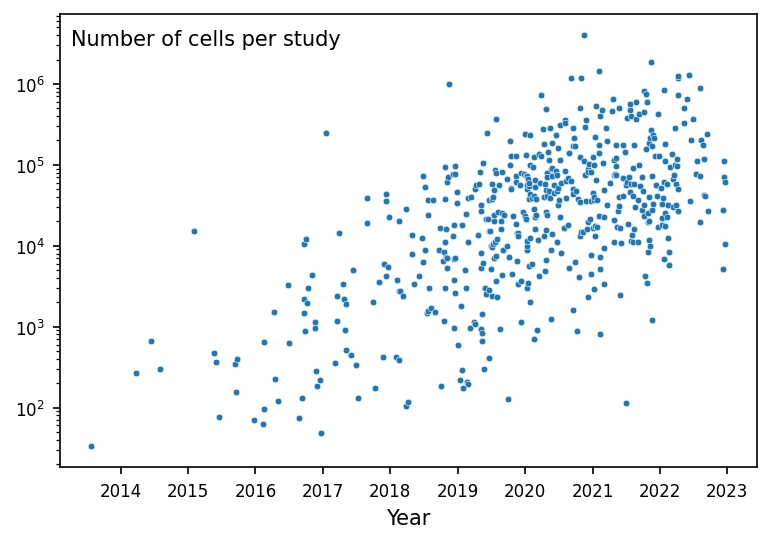

In [13]:
plt.figure(figsize=(6, 4), dpi=150)

sns.scatterplot(data=df.loc[df["year"] > 2005], x="date", y="Reported cells total", s=10)
plt.text(15800, 30e5, "Number of cells per study")

plt.yscale("log")
plt.ylabel("")
plt.xlabel("Year")

plt.yticks(size=8);
plt.xticks(size=8);

<Axes: xlabel='Number individuals', ylabel='Count'>

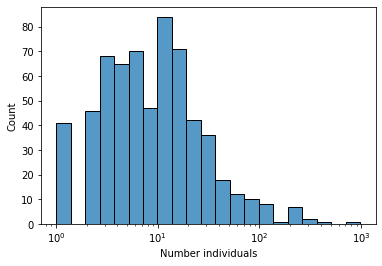

In [14]:
sns.histplot(df["Number individuals"], log_scale=True)
# plt.yscale("log")

In [15]:
df[["Number individuals"]].describe()

,Number individuals
count,630.000000
mean,20.022222
std,53.432032
min,1.000000
25%,4.000000
50%,8.000000
75%,17.000000
max,982.000000


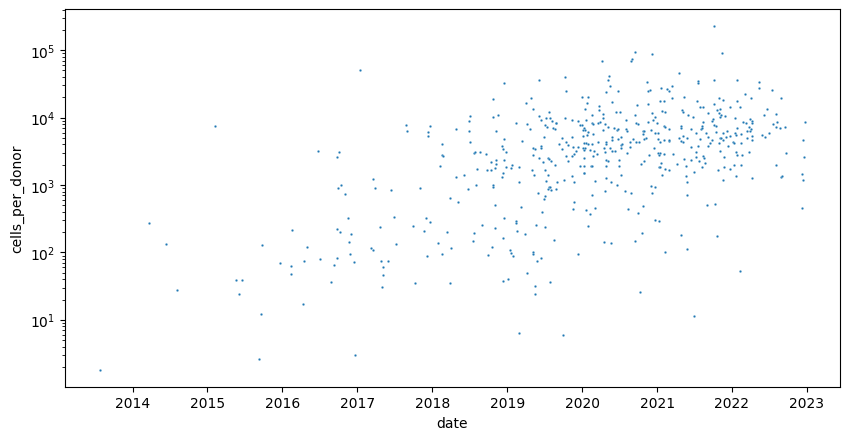

In [17]:
plt.figure(figsize=(10, 5), dpi=100)

sns.scatterplot(data=df.loc[df["year"] > 2005], x="date", y="cells_per_donor", s=3)

# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))
plt.yscale("log")

(0.0, 300.0)

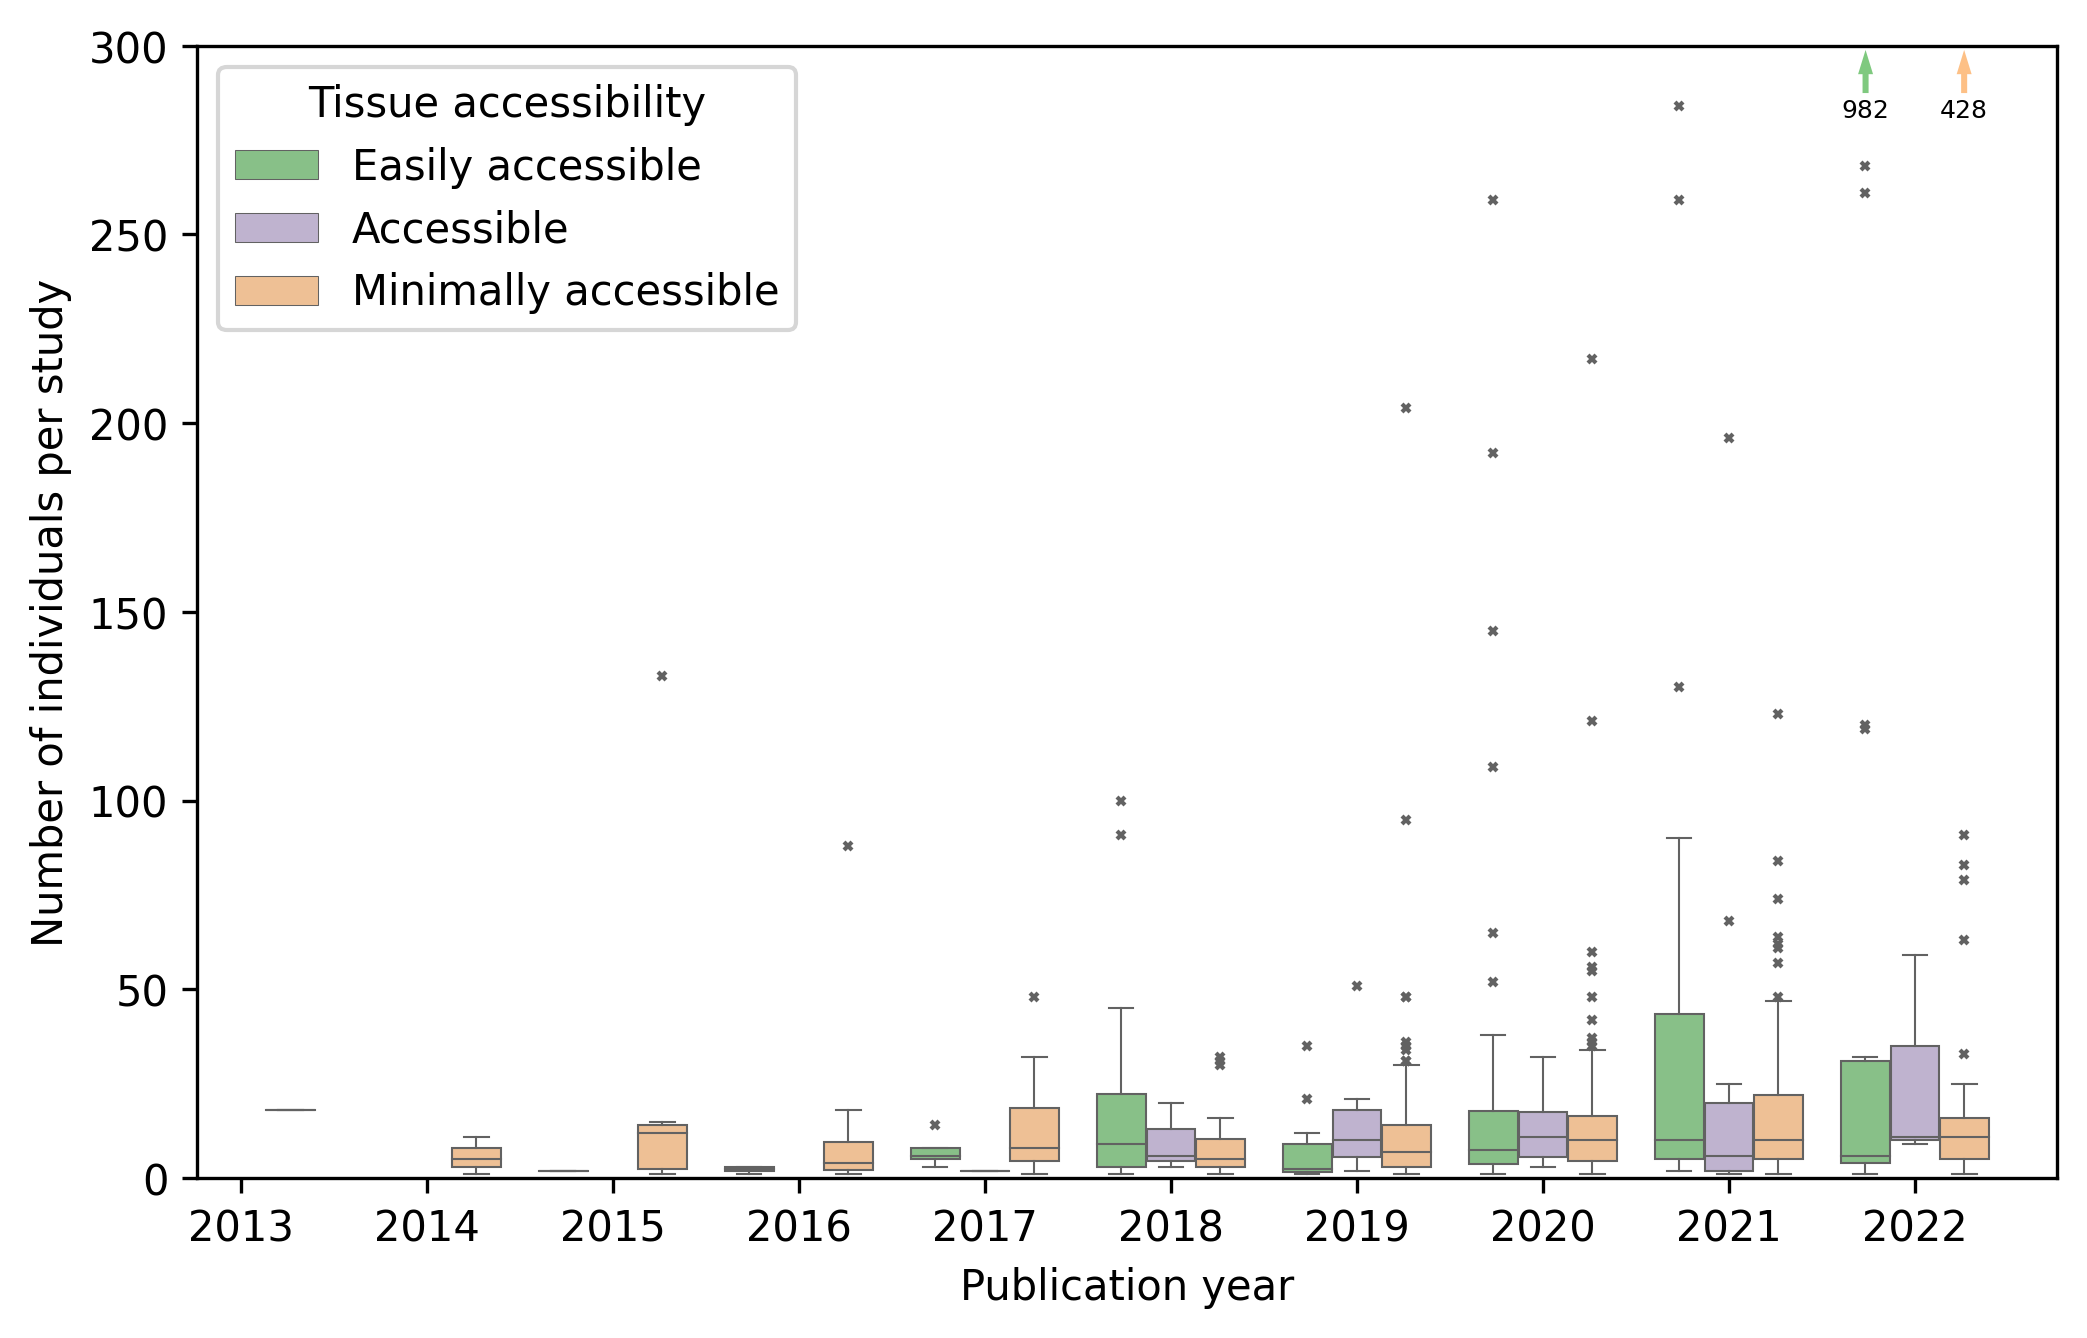

In [18]:
ylim = 300

palette = sns.color_palette("Accent")

outliers = df[df["Number individuals"] >= 300]

plt.figure(figsize=(8, 5), dpi=300)

sns.boxplot(data=df.loc[df["year"] > 2004], x="year", y="Number individuals", hue="tissue_accessibility", 
            hue_order=accessibility_types.values(), palette=palette, width=0.8, fliersize=2, linewidth=0.5,
            flierprops={"marker": "x", "linewidth": 1})

box_plots_offset = + 0.265
# Sun et al paper, 428 patients from hardly accessible tissue (see below)
plt.arrow(x=9 + box_plots_offset, y=288, dx=0, dy=5, width=.01, head_length=4, head_width=.05, edgecolor=None, color=palette[2])
plt.text(x=9 + box_plots_offset, y=281, s="428", horizontalalignment="center", fontdict={"size": 6})

# Yazar et al paper, 982 patients from accessible tissue (see below)
plt.arrow(x=9 - box_plots_offset, y=288, dx=0, dy=5, width=.01, head_length=4, head_width=.05, facecolor=None, edgecolor=None, color=palette[0])
plt.text(x=9 - box_plots_offset, y=281, s="982", horizontalalignment="center", fontdict={"size": 6})

plt.legend(title="Tissue accessibility")
plt.ylabel("Number of individuals per study")
plt.xlabel("Publication year")

plt.ylim(0, ylim)

In [19]:
outliers[["Shorthand", "year", "DOI", "tissue_accessibility", "Number individuals"]]

,Shorthand,year,DOI,tissue_accessibility,Number individuals
1690.0,Sun et al bioRxiv,2022,10.1101/2022.02.09.479797,Minimally accessible,428.0
1725.0,Yazar et al Science,2022,10.1126/science.abf3041,Easily accessible,982.0


2 outliers not shown


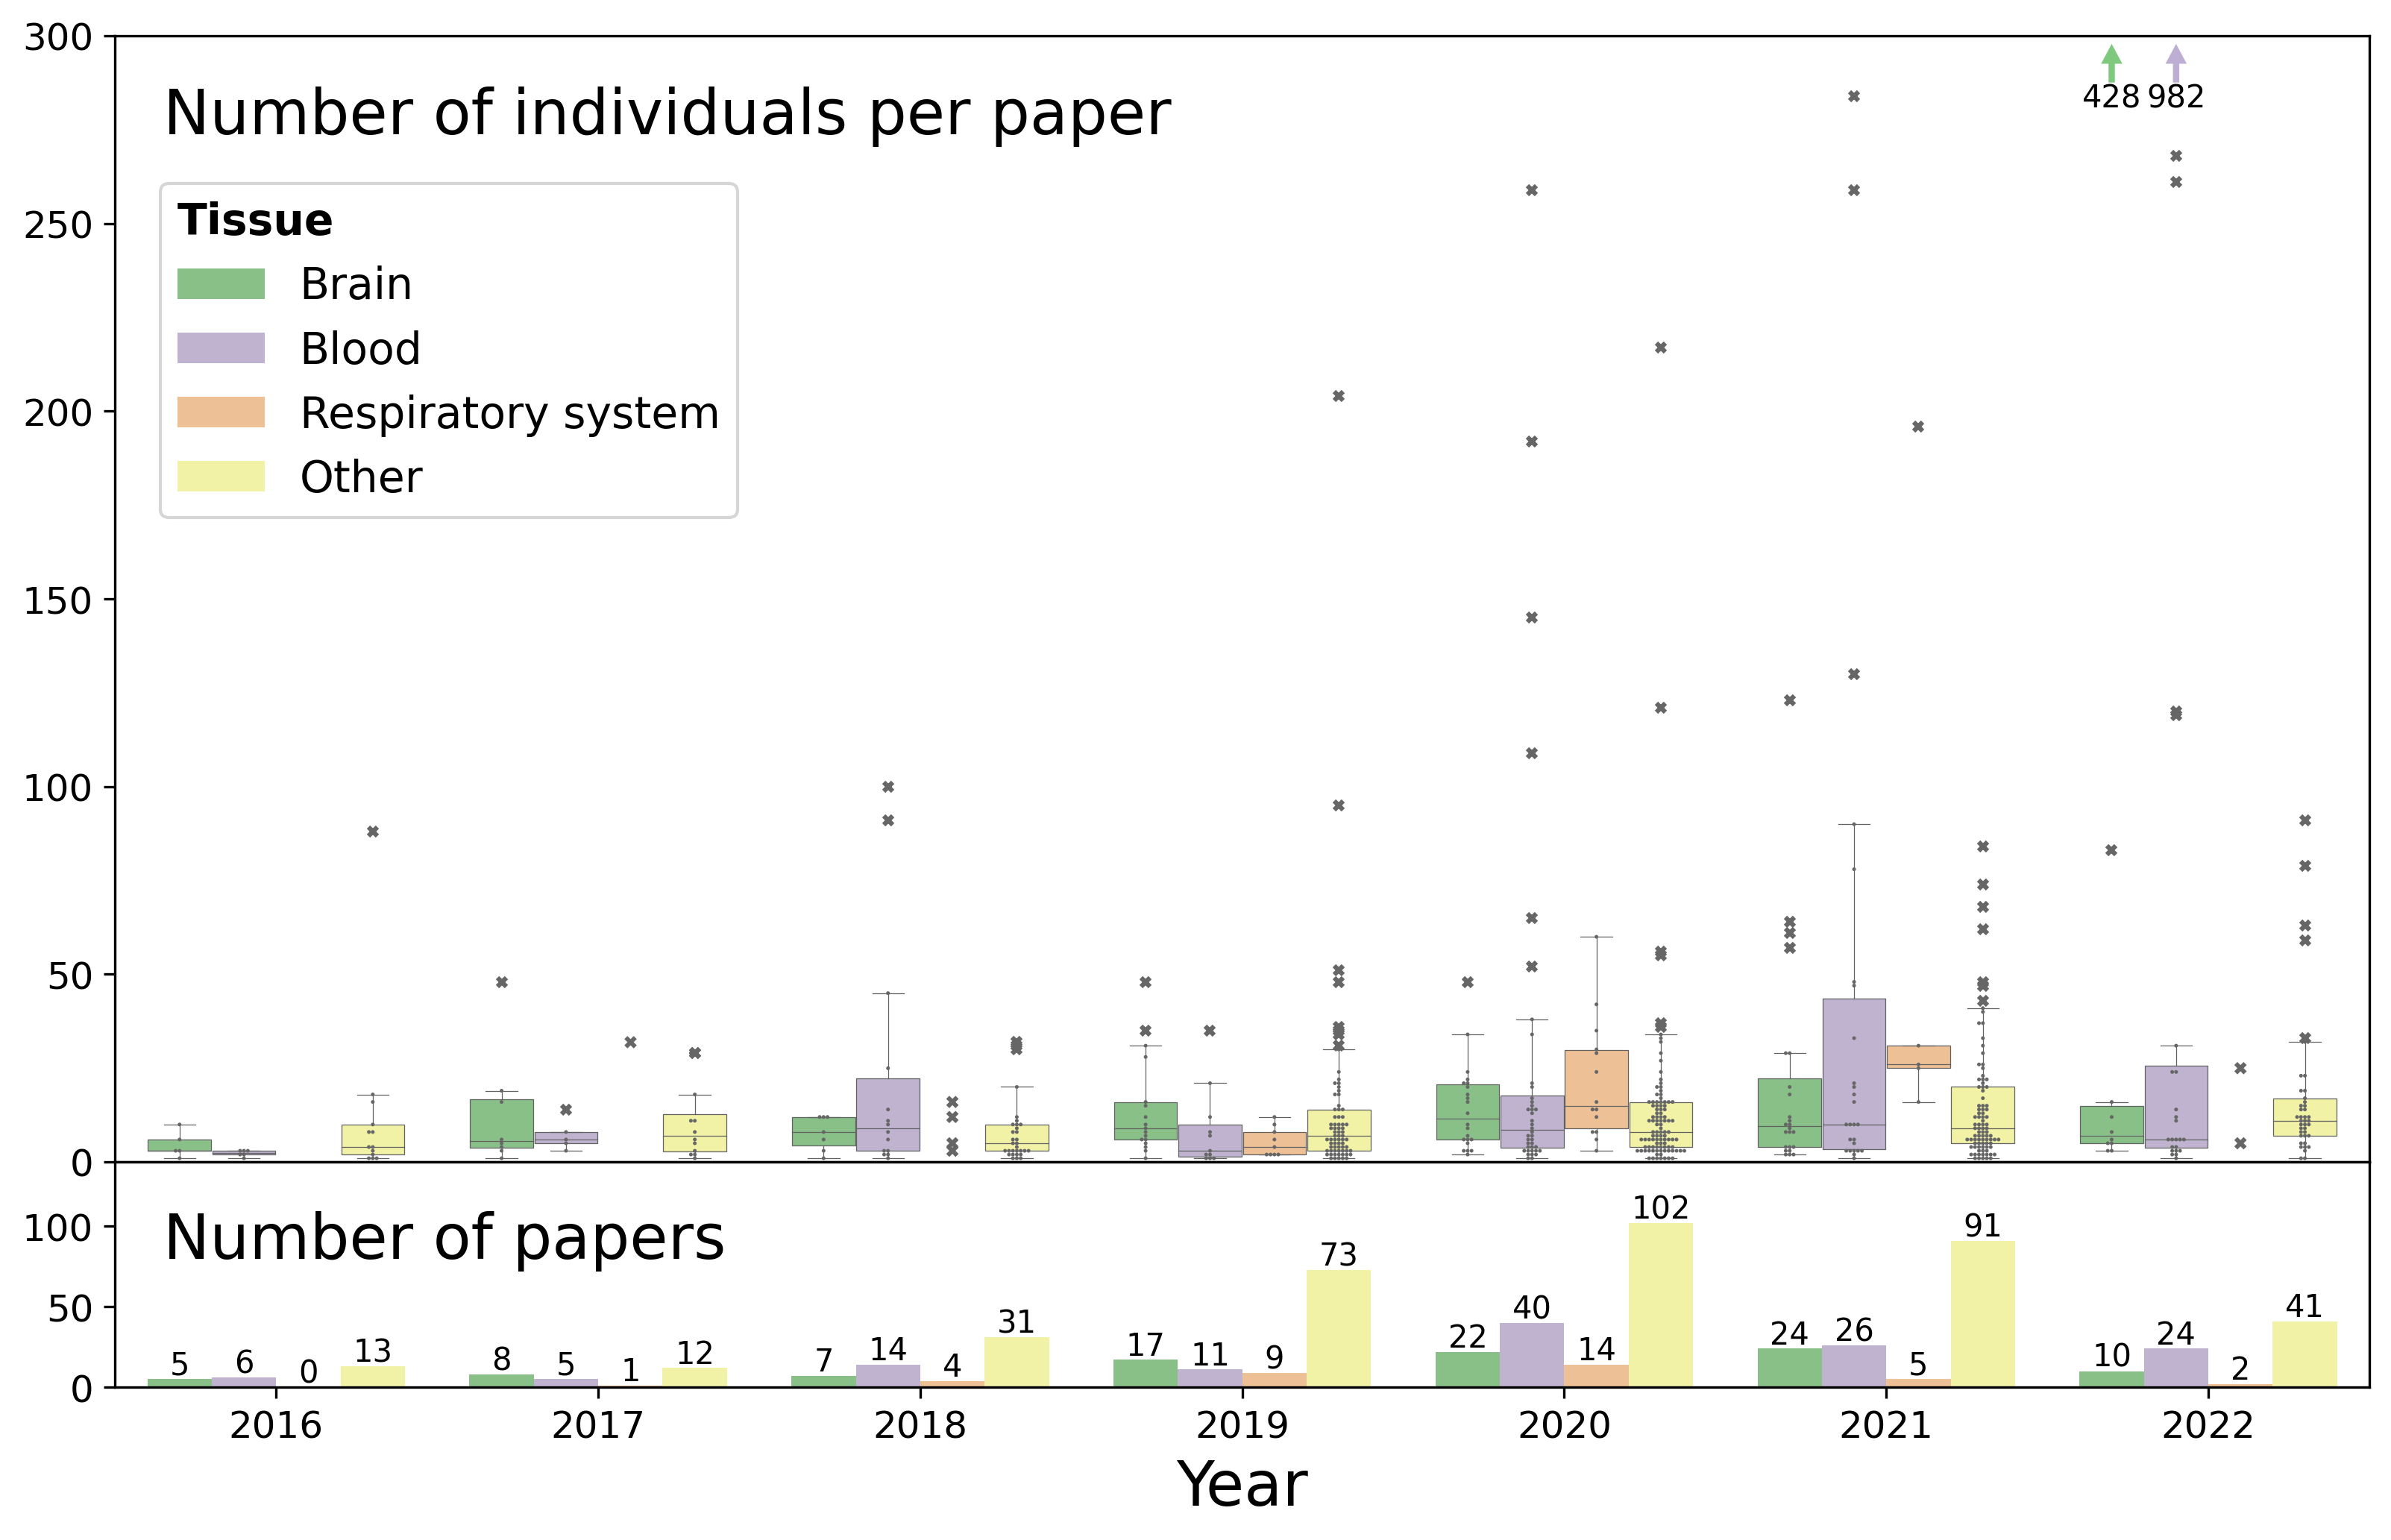

In [20]:
ylim = 300
min_observations = 5  # If there are less observations per group, don't draw the box

interesting_tissues = ["Brain", "Blood", "Respiratory system"]
palette = sns.color_palette("Accent")

tissues_df = df.copy()
tissues_df = tissues_df.loc[tissues_df["year"] > 2015]
tissues_df.loc[~tissues_df["Tissue_type"].isin(interesting_tissues), "Tissue_type"] = "Other"

start = tissues_df["year"].min()

outliers = tissues_df[tissues_df["Number individuals"] >= ylim]

fig, axes = plt.subplots(figsize=(13, 8), dpi=300, nrows=2, sharex=True,
                         gridspec_kw={"height_ratios": [5, 1], "hspace": 0})

# Plot distribution of number of individuals
sns.boxplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) >= min_observations),
    x="year",
    y="Number individuals",
    hue="Tissue_type",
    palette=palette,
    hue_order=interesting_tissues + ["Other"],
    linewidth=0.3,
    fliersize=3, 
    flierprops={"marker": "x", "markeredgewidth": 1.5, "markeredgecolor": "#666666"},
    ax=axes[0]
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) >= min_observations),
    x="year",
    y="Number individuals",
    hue="Tissue_type",
    palette=["#666666"] * 4,
    hue_order=interesting_tissues + ["Other"],
    ax=axes[0],
    size=1.2,
    dodge=True
)

# Plot points as circles where boxes are NOT plotted
sns.stripplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) < min_observations),
    x="year",
    y="Number individuals",
    hue="Tissue_type",
    palette=["#666666"] * 4,
    hue_order=interesting_tissues + ["Other"],
    ax=axes[0],
    size=4,
    dodge=True,
    marker="X",
    jitter=False
)

box_plots_offset = 0.1
# Sun et al paper, 428 patients from Brain
axes[0].arrow(x=2022 - start - 3 * box_plots_offset, y=288, dx=0, dy=5, width=.01, head_length=4,
          head_width=.05, edgecolor=None, color=palette[0])
axes[0].text(x=2022 - start - 3 * box_plots_offset, y=281, s="428", horizontalalignment="center", fontdict={"size": 10})

# Yazar et al paper, 982 patients from Blood
axes[0].arrow(x=6 - box_plots_offset, y=288, dx=0, dy=5, width=.01, head_length=4,
          head_width=.05, facecolor=None, edgecolor=None, color=palette[1])
axes[0].text(x=6 - box_plots_offset, y=281, s="982", horizontalalignment="center", fontdict={"size": 10})


# Plot number of papers per category

g = sns.countplot(data=tissues_df, x="year", hue="Tissue_type", palette=palette,
              hue_order=interesting_tissues + ["Other"], linewidth=0.3, ax=axes[1])

# Put text above bars
for bar in g.patches:
    x = bar.get_x()
    height = bar.get_height()
    axes[1].text(x=x + box_plots_offset, y=height+3, s=int(height), ha="center", size=10)

axes[0].legend().remove()
axes[1].legend(
    loc=(0.02, 3.86),
    title="Tissue",
    alignment="left",
    title_fontproperties={"weight": "bold", "size": 14},
    fontsize=14
)
# axes[1].invert_yaxis()
# axes[1].axis("off")

axes[0].set_xlabel("")
axes[1].set_xlabel("Year", size=20)
axes[0].set_ylabel("")

axes[0].set_ylim(0, ylim)
axes[1].set_ylim(0, 140)
axes[1].set_ylabel("")

axes[0].text(x=-0.35, y=ylim - 26, s="Number of individuals per paper", size=20)
axes[1].text(x=-0.35, y=80, s="Number of papers", size=20)

axes[0].tick_params(axis="both", which="major", labelsize=12)
axes[1].tick_params(axis="both", which="major", labelsize=12)

print((tissues_df["Number individuals"] >= ylim).sum(), "outliers not shown")

In [21]:
outliers[["Shorthand", "year", "DOI", "Tissue_type", "tissue_accessibility", "Number individuals"]]

,Shorthand,year,DOI,Tissue_type,tissue_accessibility,Number individuals
1690.0,Sun et al bioRxiv,2022,10.1101/2022.02.09.479797,Brain,Minimally accessible,428.0
1725.0,Yazar et al Science,2022,10.1126/science.abf3041,Blood,Easily accessible,982.0


Text(375.29166666666663, 0.5, '')

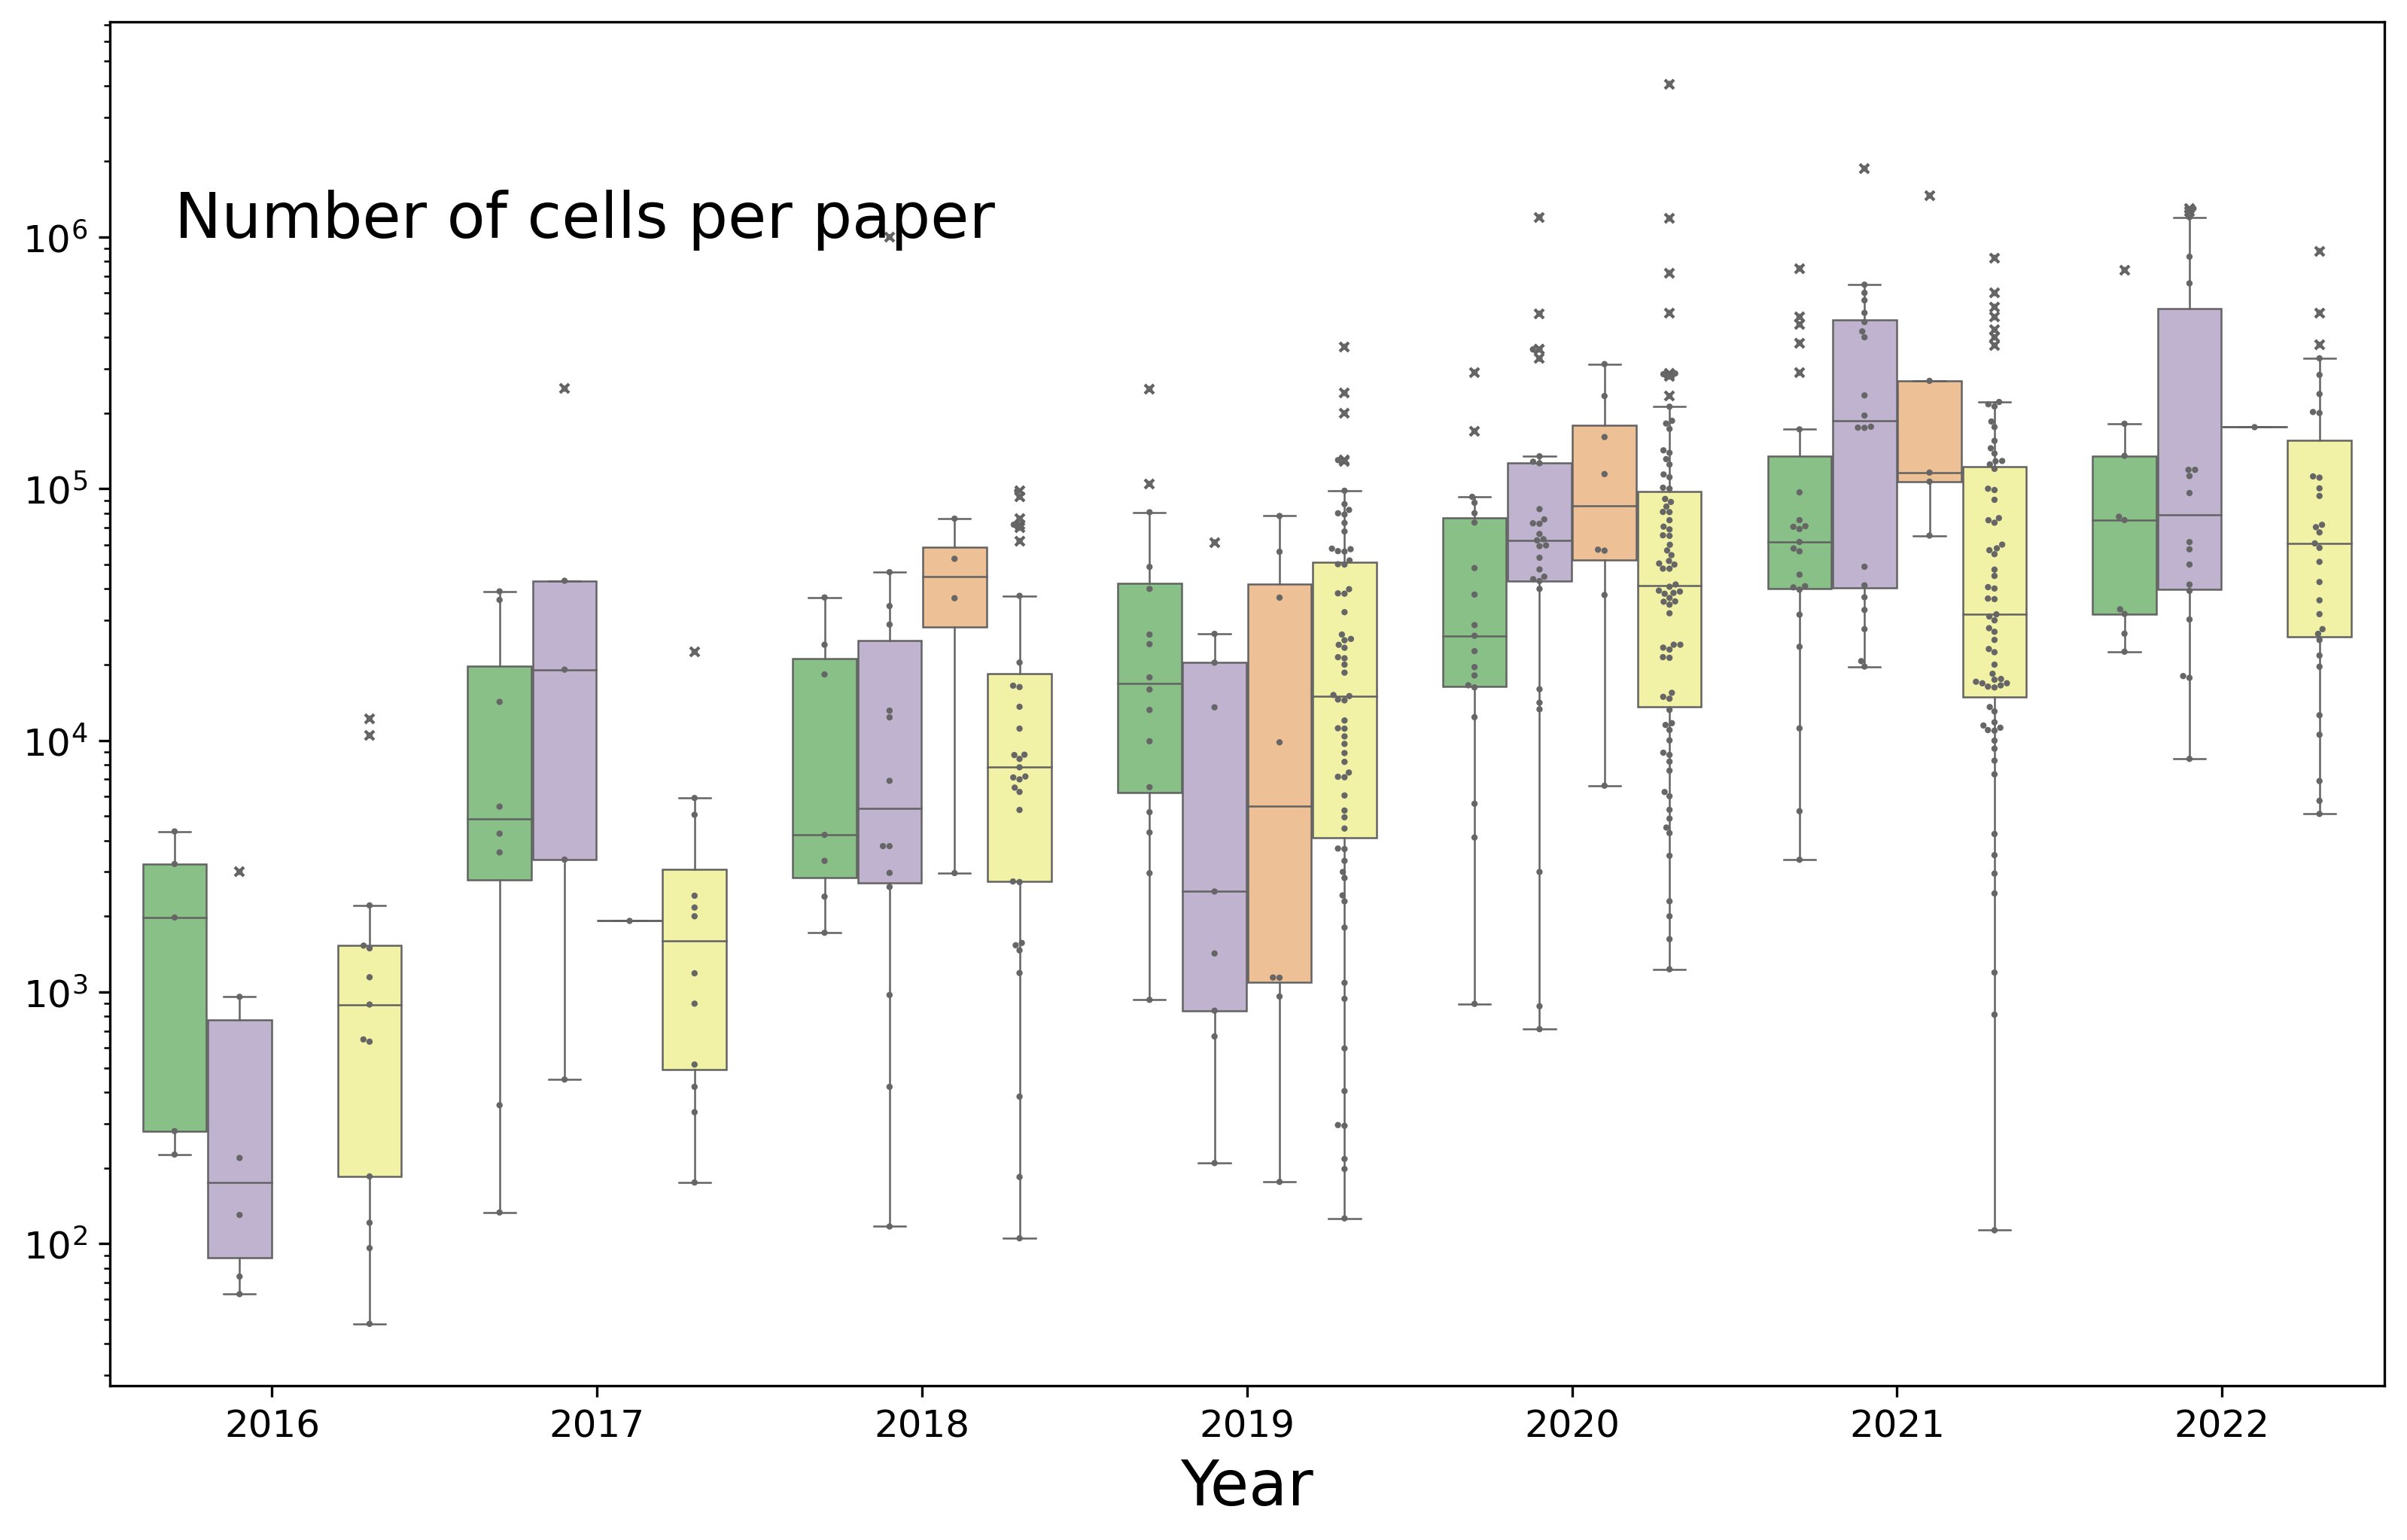

In [22]:
plt.figure(figsize=(13, 8), dpi=300)

# ylim = 2e6
# outliers = tissues_df[tissues_df["Reported cells total"] >= ylim]

sns.boxplot(data=tissues_df, x="year", y="Reported cells total", hue="Tissue_type", palette=palette,
            hue_order=interesting_tissues + ["Other"], linewidth=0.6, fliersize=3, 
            flierprops={"marker": "x", "linewidth": 1})
sns.swarmplot(data=tissues_df, x="year", y="Reported cells total", hue="Tissue_type", palette=["#666666"] * 4,
              hue_order=interesting_tissues + ["Other"], size=2, dodge=True, legend=False)

plt.yscale("log")

plt.text(x=-0.3, y=ylim + 10e5, s="Number of cells per paper", size=20)

plt.tick_params(axis="both", which="major", labelsize=12)

plt.legend().remove()
# plt.legend(loc=(1.02, 0), title="Tissue", alignment="left", title_fontproperties={"weight": "bold"})

plt.xlabel("Year", size=20)
plt.ylabel("")

# plt.ylim(0, ylim)

0 outliers not shown


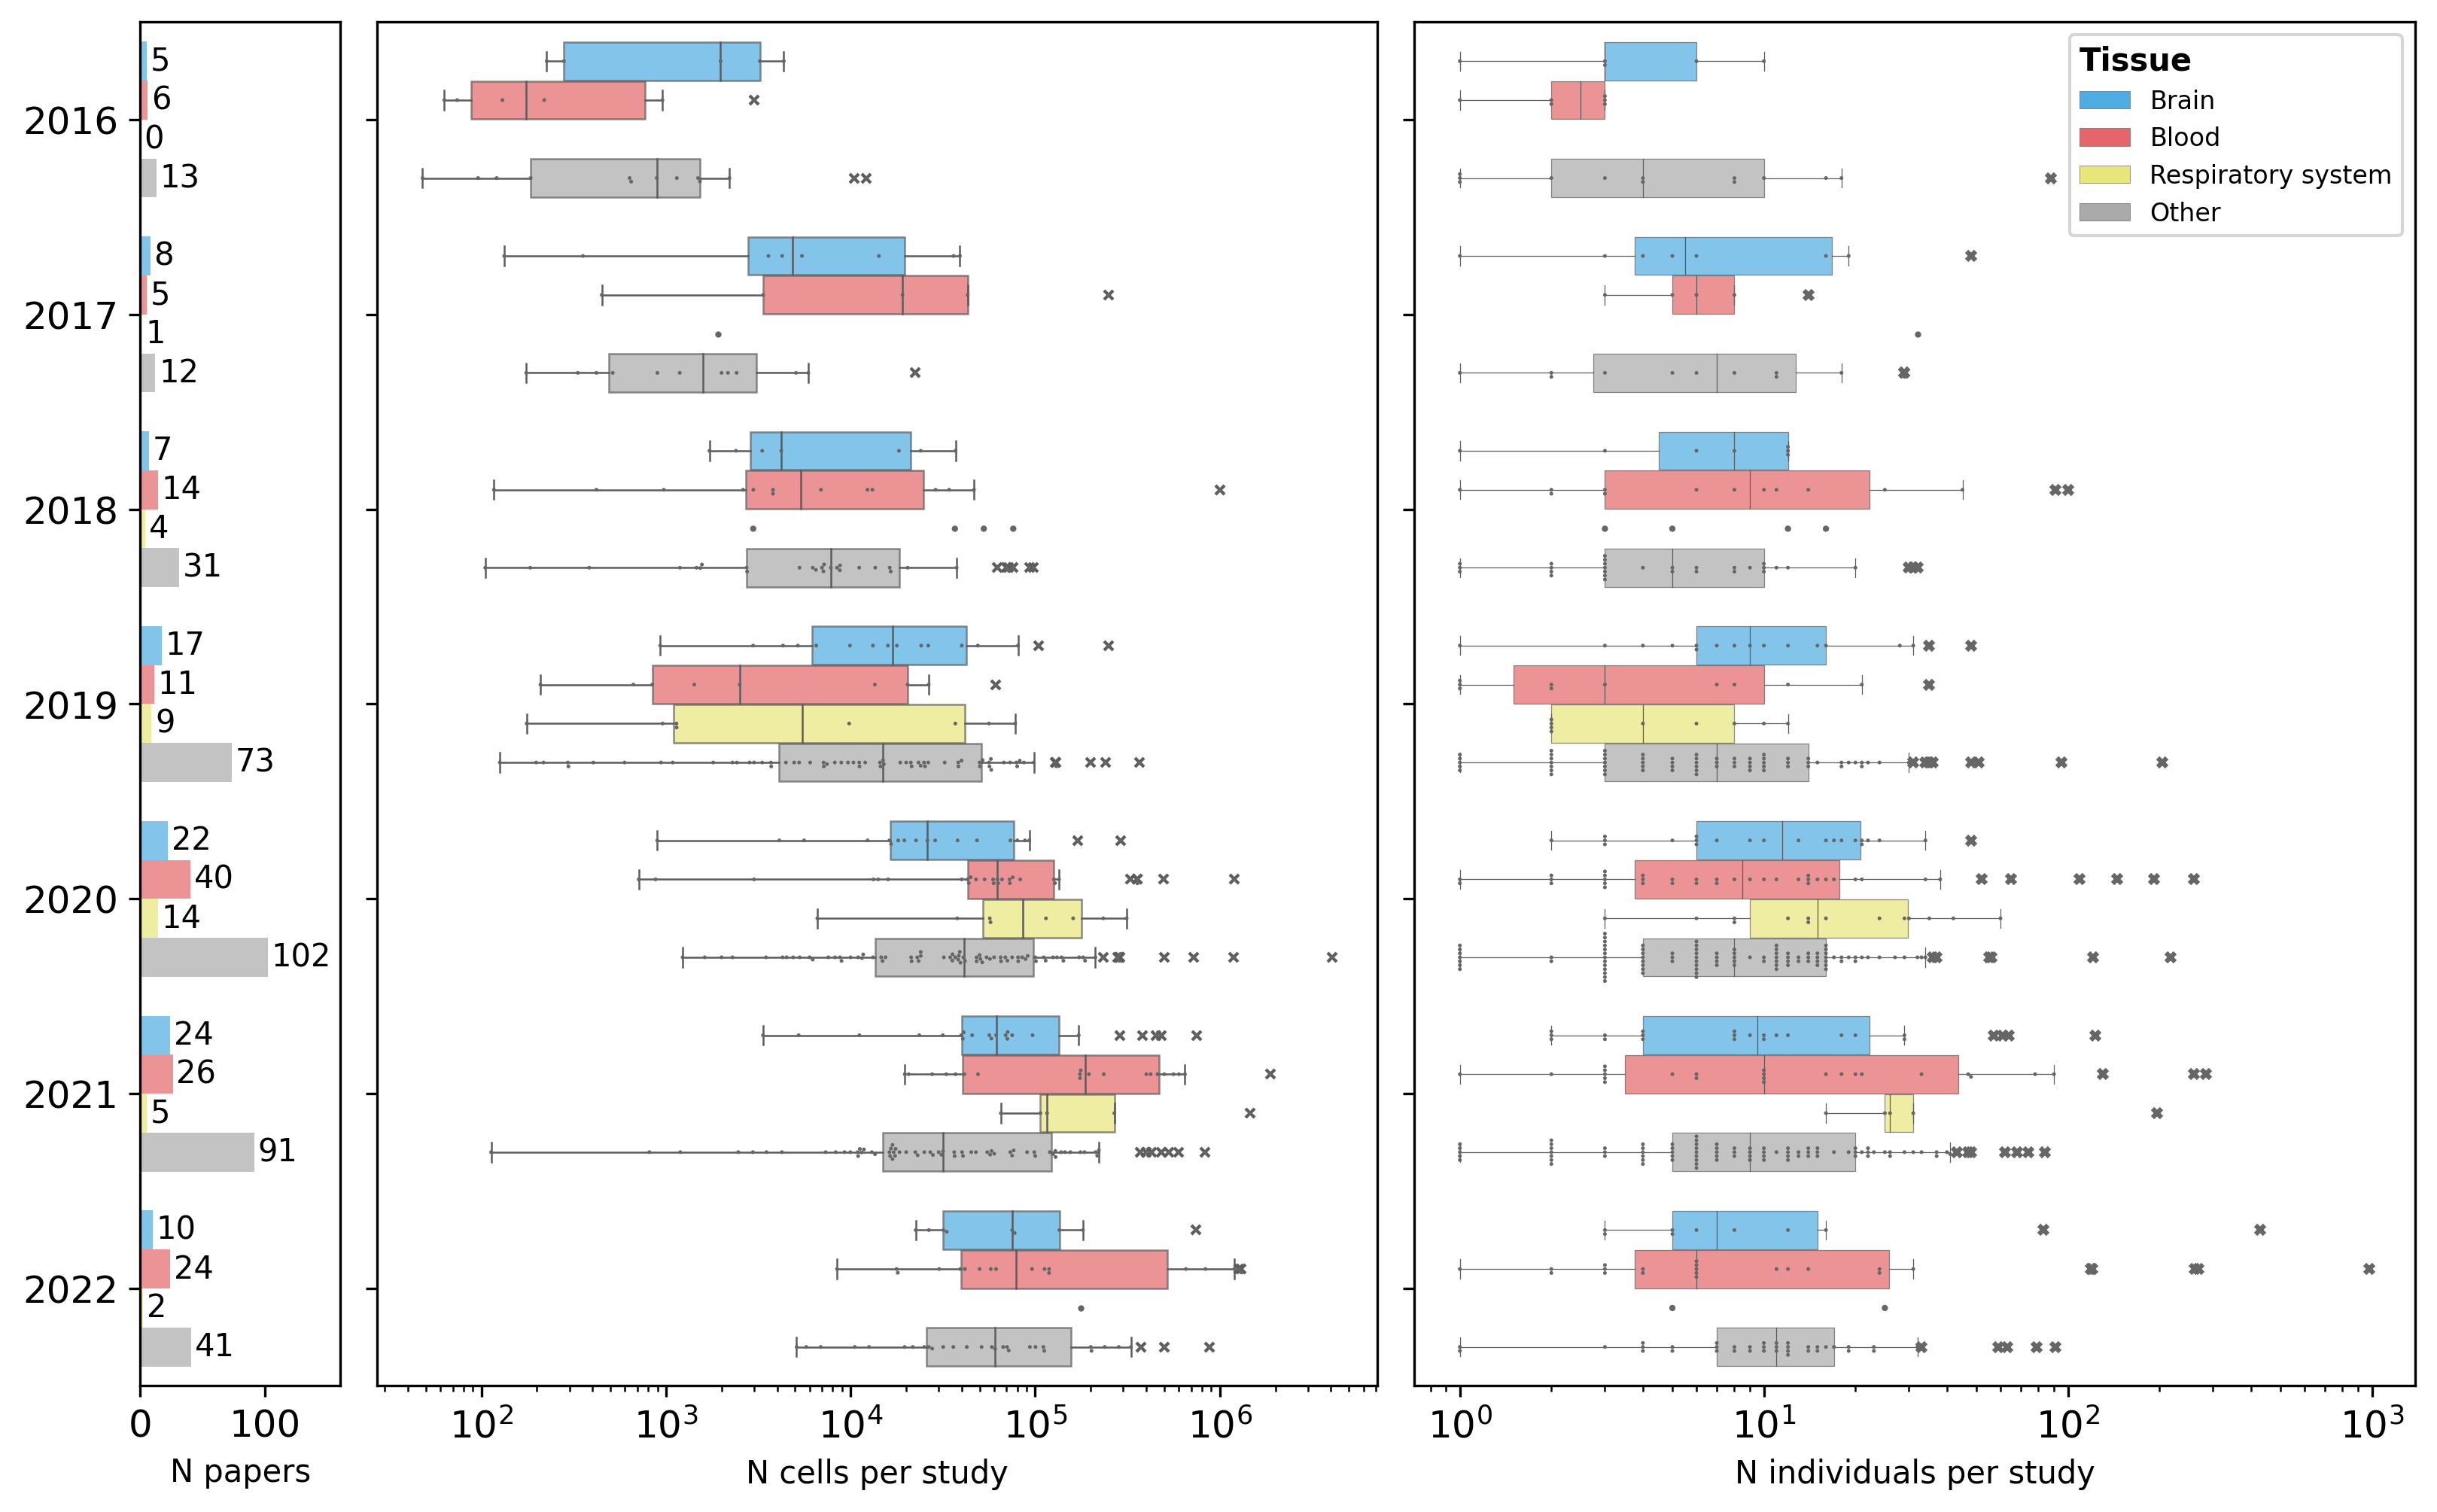

In [23]:
N_PAPERS_IDX = 0
N_INDS_IDX = 2
N_CELLS_IDX = 1
NO_BOXES_POINT_SIZE = 2

n_inds_plot_lim = 10000
min_observations = 5  # If there are less observations per group, don't draw the box

interesting_tissues = ["Brain", "Blood", "Respiratory system"]
# palette = sns.color_palette("Accent")
palette = ["#37B2FA", "#FA5056", "#FAF769", "#AAAAAA"]

tissues_df = df.copy()
tissues_df = tissues_df.loc[tissues_df["year"] > 2015]
tissues_df.loc[~tissues_df["Tissue_type"].isin(interesting_tissues), "Tissue_type"] = "Other"

outliers = tissues_df[tissues_df["Number individuals"] >= n_inds_plot_lim]

fig, axes = plt.subplots(figsize=(13, 8), dpi=300, ncols=3, sharey=True,
                         gridspec_kw={"width_ratios": [1, 5, 5], "wspace": 0.05})

# Plot distribution of number of individuals
sns.boxplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) >= min_observations),
    y="year",
    x="Number individuals",
    orient="h",
    hue="Tissue_type",
    palette=palette,
    hue_order=interesting_tissues + ["Other"],
    linewidth=0.3,
    fliersize=3, 
    flierprops={"marker": "x", "markeredgewidth": 1.5, "markeredgecolor": "#666666"},
    ax=axes[N_INDS_IDX],
    boxprops={"alpha": 0.7}
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) >= min_observations),
    y="year",
    x="Number individuals",
    orient="h",
    hue="Tissue_type",
    palette=["#666666"] * 4,
    hue_order=interesting_tissues + ["Other"],
    ax=axes[N_INDS_IDX],
    size=1.2,
    dodge=True,
    legend=None
)

# Plot points as circles where boxes are NOT plotted
sns.stripplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) < min_observations),
    y="year",
    x="Number individuals",
    orient="h",
    hue="Tissue_type",
    palette=["#666666"] * 4,
#     palette=palette,
    hue_order=interesting_tissues + ["Other"],
    ax=axes[N_INDS_IDX],
    size=NO_BOXES_POINT_SIZE,
    dodge=True,
    marker="o",
    jitter=False,
    legend=None
)


box_plots_offset = 0.1
start = tissues_df["year"].min()
tissue_idxs = {"Brain": 0, "Blood": 1, "Respiratory system": 2, "Other": 3}
offsets = [3, 1, -1, -3]  # Guessed from the plot

# For each outlier plot #individuals as text, and draw arrow pointing to the plot's edge
for _, row in outliers.iterrows():
    tissue = row["Tissue_type"]
    tissue_idx = tissue_idxs[tissue]
    offset = offsets[tissue_idx]
    axes[N_INDS_IDX].arrow(
        y=2022 - start - offset * box_plots_offset,
        x=n_inds_plot_lim - 19,
        dx=12,
        dy=0,
        width=.07,
        head_length=4,
        head_width=.15,
        edgecolor=None,
        color=palette[tissue_idx], 
        alpha=0.7
    )
    axes[N_INDS_IDX].text(
        y=2022 - start - offset * box_plots_offset,
        x=n_inds_plot_lim - 20,
        s=str(int(row["Number individuals"])),
        horizontalalignment="right",
        verticalalignment="center",
        fontdict={"size": 10})

# Plot number of papers per category

g = sns.countplot(data=tissues_df, y="year", hue="Tissue_type", palette=palette, orient="h",
              hue_order=interesting_tissues + ["Other"], linewidth=0.3, ax=axes[N_PAPERS_IDX], alpha=0.7)

# Put text above bars
for bar in g.patches:
    y = bar.get_y()
    length = bar.get_width()
    axes[N_PAPERS_IDX].text(y=y + box_plots_offset, x=length+3, s=int(length), ha="left", va="center", size=10)

# Plot number of cells per paper
sns.boxplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) >= min_observations),
    y="year",
    x="Reported cells total",
    hue="Tissue_type",
    orient="h",
    palette=palette,
    hue_order=interesting_tissues + ["Other"],
    linewidth=0.6,
    fliersize=3,
    flierprops={"marker": "x", "linewidth": 1},
    ax=axes[N_CELLS_IDX],
    boxprops={"alpha": 0.7}
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) >= min_observations),
    y="year",
    x="Reported cells total",
    orient="h",
    hue="Tissue_type",
    palette=["#666666"] * 4,
    hue_order=interesting_tissues + ["Other"],
    ax=axes[N_CELLS_IDX],
    size=1.2,
    dodge=True,
    legend=None
)

# Plot points as circles where boxes are NOT plotted
sns.stripplot(
    data=tissues_df.groupby(["year", "Tissue_type"]).filter(lambda x: len(x) < min_observations),
    y="year",
    x="Reported cells total",
    orient="h",
    hue="Tissue_type",
    palette=["#666666"] * 4,
#     palette=palette,
    hue_order=interesting_tissues + ["Other"],
    ax=axes[N_CELLS_IDX],
    size=NO_BOXES_POINT_SIZE,
    dodge=True,
    marker="o",
    jitter=False,
    legend=None
)

    
axes[N_PAPERS_IDX].legend().remove()
axes[N_CELLS_IDX].legend().remove()
axes[N_INDS_IDX].legend(
    loc="upper right",
    title="Tissue",
    alignment="left",
    title_fontproperties={"weight": "bold", "size": 10},
    fontsize=8
)
# axes[N_PAPERS_IDX].axis("off")

axes[N_PAPERS_IDX].set_xlabel("N papers")
axes[N_INDS_IDX].set_xlabel("N individuals per study")
axes[N_CELLS_IDX].set_xlabel("N cells per study")

# axes[N_PAPERS_IDX].set_xlabel("Year", size=20)
axes[N_CELLS_IDX].set_ylabel("")
axes[N_INDS_IDX].set_ylabel("")
axes[N_PAPERS_IDX].set_ylabel("")

# axes[N_INDS_IDX].set_xlim(0, n_inds_plot_lim)
axes[N_INDS_IDX].set_xscale("log")
axes[N_PAPERS_IDX].set_xlim(0, 160)
axes[N_PAPERS_IDX].set_ylabel("")
axes[N_CELLS_IDX].set_xscale("log")

# axes[N_PAPERS_IDX].text(x=-0.35, y=ylim - 26, s="Number of individuals per paper", size=20)
# axes[N_PAPERS_IDX].text(x=-0.35, y=80, s="Number of papers", size=20)

axes[N_CELLS_IDX].tick_params(axis="both", which="major", labelsize=12)
axes[N_INDS_IDX].tick_params(axis="both", which="major", labelsize=12)
axes[N_PAPERS_IDX].tick_params(axis="both", which="major", labelsize=12)

print((tissues_df["Number individuals"] >= n_inds_plot_lim).sum(), "outliers not shown")

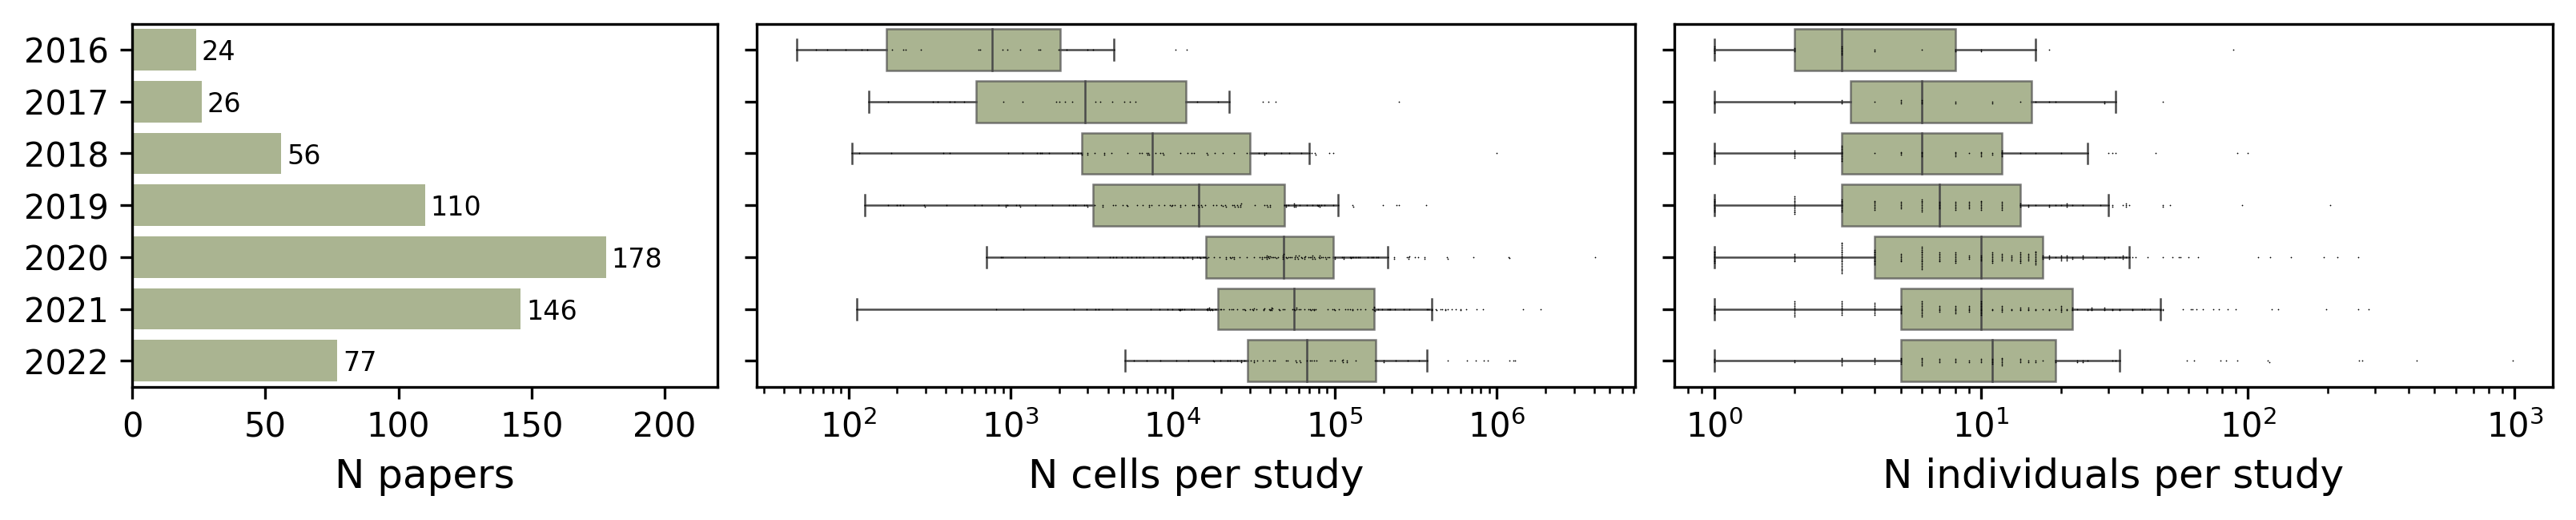

In [24]:
N_PAPERS_IDX = 0
N_INDS_IDX = 2
N_CELLS_IDX = 1
NO_BOXES_POINT_SIZE = 2
PLOT_COLOR = "#8A9E59"

boxplot_params = dict(
    orient="h",
    linewidth=0.6,
    fliersize=3, 
    flierprops={"marker": "x", "markeredgewidth": 1.5, "markeredgecolor": "#666666"},
    boxprops={"alpha": 0.7},
    color=PLOT_COLOR,
    showfliers=False
)

swarmplot_params = dict(
    orient="h",
    color="black",
    size=0.42,
    legend=None
)

tissues_df = df.copy()
tissues_df = tissues_df.loc[tissues_df["year"] > 2015]

fig, axes = plt.subplots(figsize=(13, 2), dpi=300, ncols=3, sharey=True,
                         gridspec_kw={"width_ratios": [2, 3, 3], "wspace": 0.05})

# Plot distribution of number of individuals
sns.boxplot(
    data=tissues_df,
    y="year",
    x="Number individuals",
    ax=axes[N_INDS_IDX],
    **boxplot_params
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df,
    y="year",
    x="Number individuals",
    ax=axes[N_INDS_IDX],
    **swarmplot_params
)

# Plot number of papers per category

g = sns.countplot(
    data=tissues_df,
    y="year",
    orient="h",
    linewidth=0.3,
    ax=axes[N_PAPERS_IDX],
    alpha=0.7,
    color=PLOT_COLOR
)

# Put text above bars
for bar in g.patches:
    y = bar.get_y()
    length = bar.get_width()
    axes[N_PAPERS_IDX].text(y=y + 0.45, x=length+2, s=int(length), ha="left", va="center", size=8)

# Plot number of cells per paper
sns.boxplot(
    data=tissues_df,
    y="year",
    x="Reported cells total",
    ax=axes[N_CELLS_IDX],
    **boxplot_params
)

# Plot points as circles over boxplots (where boxes are plotted)
sns.swarmplot(
    data=tissues_df,
    y="year",
    x="Reported cells total",
    ax=axes[N_CELLS_IDX],
    **swarmplot_params
)

axes[N_PAPERS_IDX].set_xlabel("N papers", size=12)
axes[N_INDS_IDX].set_xlabel("N individuals per study", size=12)
axes[N_CELLS_IDX].set_xlabel("N cells per study", size=12)

# axes[N_PAPERS_IDX].set_xlabel("Year", size=20)
axes[N_CELLS_IDX].set_ylabel("")
axes[N_INDS_IDX].set_ylabel("")
axes[N_PAPERS_IDX].set_ylabel("")

# axes[N_INDS_IDX].set_xlim(0, n_inds_plot_lim)
axes[N_INDS_IDX].set_xscale("log")
axes[N_PAPERS_IDX].set_xlim(0, 220)
axes[N_PAPERS_IDX].set_ylabel("")
axes[N_CELLS_IDX].set_xscale("log")

axes[N_CELLS_IDX].tick_params(axis="both", which="major", labelsize=10)
axes[N_INDS_IDX].tick_params(axis="both", which="major", labelsize=10)
axes[N_PAPERS_IDX].tick_params(axis="both", which="major", labelsize=10)

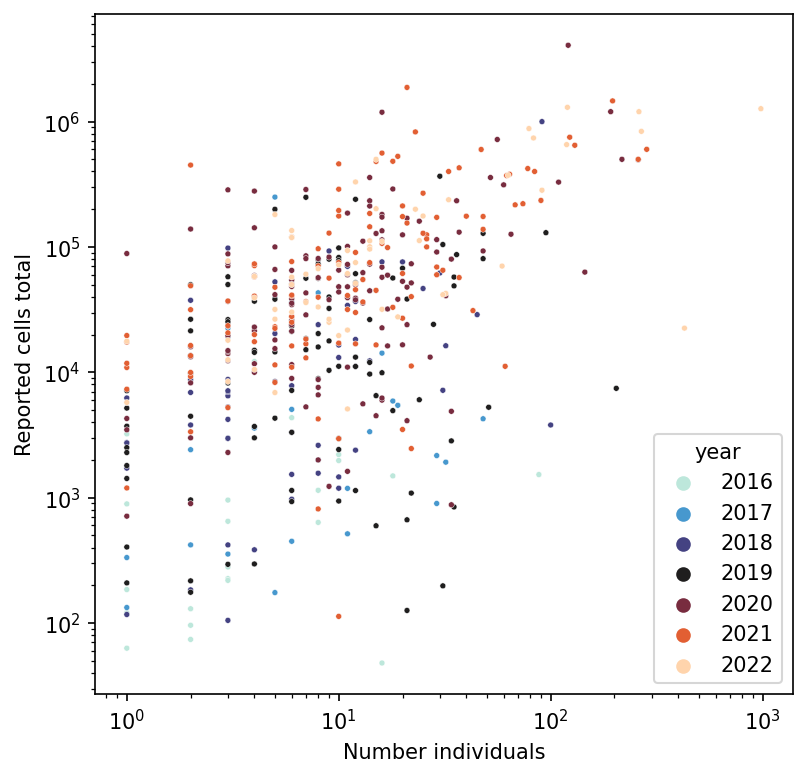

In [25]:
plt.figure(figsize=(6, 6), dpi=150)
sns.scatterplot(tissues_df, x="Number individuals", y="Reported cells total", hue="year", palette="icefire", s=8)
plt.xscale("log")
plt.yscale("log")

<Axes: xlabel='Number individuals', ylabel='Reported cells total'>

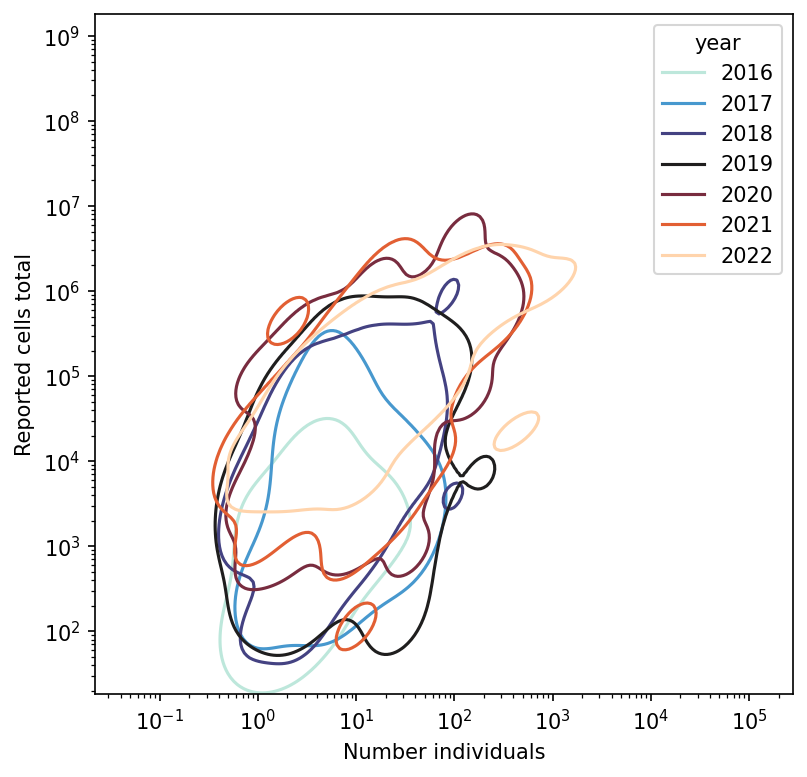

In [26]:
plt.figure(figsize=(6, 6), dpi=150)
sns.kdeplot(tissues_df, x="Number individuals", y="Reported cells total", hue="year", palette="icefire",
            log_scale=True, levels=1, cut=8)

In [27]:
tissues_df.drop(["Contrasts", "excluded", "DOI_oroginal", "do_DOI_match", "Shorthand_origina",
                 "do_shorthands_match", "Number individuals original"],
                axis=1).to_csv(
    "/Users/vladimir.shitov/Documents/science/PhD/2023_02_donors_plot/data/supplementary_1_papers_info.csv"
)